In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from PIL import Image
import cv2
import os
import torch
import torch.nn.functional as F
from torch import nn
import itertools
from torch.utils.tensorboard import SummaryWriter
import random
import gc
from cebra_utils import *

In [2]:
#check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Iterate through all files in /mnt/teams/Tsuchitori/Allen-movie/VISP/ and then for each one with a unuique prefix move all of those to a new folder located at Allen-movie/VISP/unique_prefix
# # This is done to make it easier to iterate through the files in the next step
# import shutil
# directorty = '/mnt/teams/Tsuchitori/Allen-movie/VISP/'
# for filename in os.listdir(directorty):
#     if filename.endswith(".tif"):
#         prefix = filename.split('_')[0]
#         os.makedirs(directorty + prefix, exist_ok=True)
#         shutil.copy(directorty + filename, directorty + prefix + '/' + filename)

In [4]:
data_directory = '/mnt/teams/Tsuchitori/Allen-movie/'
neural_data_paths = [data_directory + 'VISP/' + x for x in os.listdir('/mnt/teams/Tsuchitori/Allen-movie/VISP') if x.split('.')[-1] != 'tif']

behavior_data_paths = [  data_directory + 'movie/']

dino_paths = [  data_directory + 'dino/' for _ in neural_data_paths] 


In [5]:
def init_dataloader(brain_data, feature_data, label_data, num_steps, time_offset, conditional, batch_size=1, cebra_offset=None ):
    datasets = []
    print('loading data')
    for session in zip(brain_data, feature_data, label_data):
        brain_data_tensor  = torch.FloatTensor(session[0])
        feature_data_tensor = torch.FloatTensor(session[1])
        label_data_tensor = torch.Tensor(session[2]).type(torch.LongTensor)
        datasets.append(cebra.data.datasets.TensorDataset(brain_data_tensor, continuous=feature_data_tensor, discrete=label_data_tensor, offset=cebra_offset))
    dataset_collection = cebra.data.datasets.DatasetCollection(*datasets)
    return cebra.data.multi_session.MixedMultiSessionDataLoader(
        dataset=dataset_collection,
        batch_size=batch_size,
        num_steps=num_steps,
        time_offset=time_offset,
        conditional=conditional,
    ).to('cuda')

def init_dataloader_single_session(brain_data, feature_data, label_data, num_steps, time_offset, conditional, batch_size=1, cebra_offset=None ):
    brain_data_tensor  = torch.FloatTensor(brain_data)
    feature_data_tensor = torch.FloatTensor(feature_data)
    label_data_tensor = torch.Tensor(label_data).type(torch.LongTensor)
    dataset = cebra.data.datasets.TensorDataset(brain_data_tensor, continuous=feature_data_tensor, offset=cebra_offset)
    return cebra.data.single_session.ContinuousDataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_steps=num_steps,
        time_offset=time_offset,
        conditional=conditional,
    ).to('cuda')



In [6]:
def flatten_features(features):
    return [(feature.flatten()) for feature in features]

def load_partial_data2D(brain_paths, behvaior_paths, min, max, num_steps, time_offset, conditional, batch_size, cebra_offset):
    brain_data, feature_data, label_data = [], [], []
    for path in zip(brain_paths, behvaior_paths):
        print('importing from: ' + path[0] + ' and ' + path[1])
        brain_data_temp, name_data_temp = import_data(path[0], lambda x: process_brain(x), min, max)
        feature_data_temp, _ = import_data(path[1], lambda x: np.squeeze(x), min, max)
        brain_data.append(flatten_data(brain_data_temp))
        feature_data.append(flatten_data(feature_data_temp))
        # Get move nomove labels from name data 
        label_data_temp = []
        for iter, name in enumerate(name_data_temp):
            if name.split('_')[0] == 'nomove':
                label_data_temp.extend( np.zeros(len(brain_data_temp[iter])))
            else:
                label_data_temp.extend( np.ones(len(brain_data_temp[iter])))
        label_data.append(label_data_temp)
        del brain_data_temp
        del feature_data_temp
        del label_data_temp
        del name_data_temp
        del _
        gc.collect()
    return init_dataloader(brain_data, feature_data, label_data, num_steps, time_offset, conditional, batch_size, cebra_offset)

def load_single_session(brain_path, behavaior_path, min, max, num_steps, time_offset, conditional, batch_size, cebra_offset):
    brain_data, feature_data, label_data = [], [], []
    brain_data_temp, name_data_temp = import_data(brain_path, lambda x: process_brain(x), min, max)
    feature_data_temp, _ = import_data(behavaior_path, lambda x: np.squeeze(x), min, max)
    brain_data.append(flatten_data(brain_data_temp))
    feature_data.append(flatten_data(feature_data_temp))
    # Get move nomove labels from name data 
    for iter, name in enumerate(name_data_temp):
        if name.split('_')[0] == 'nomove':
            label_data.extend( np.zeros(len(brain_data_temp[iter])))
        else:
            label_data.extend( np.ones(len(brain_data_temp[iter])))
    # squeeze brain and feature data
    brain_data = np.squeeze(np.array(brain_data))
    feature_data = np.squeeze(np.array(feature_data))
    return init_dataloader_single_session(brain_data, feature_data, label_data, num_steps, time_offset, conditional, batch_size, cebra_offset)

def load_single_session_2D(brain_path, behavaior_path, min, max, num_steps, time_offset, conditional, batch_size, cebra_offset):
    brain_data, feature_data, label_data = [], [], []
    brain_data_temp, name_data_temp = import_data(brain_path, lambda x: np.array([cv2.resize(brain_frame, (128, 128)) for brain_frame in x]), min, max)
    print(np.array(brain_data_temp).shape)
    feature_data_temp, _ = import_data(behavaior_path, lambda x: np.squeeze(x), min, max)
    brain_data.append(flatten_data(brain_data_temp))
    feature_data.append(flatten_data(feature_data_temp))
    # Get move nomove labels from name data 
    for iter, name in enumerate(name_data_temp):
        if name.split('_')[0] == 'nomove':
            label_data.extend( np.zeros(len(brain_data_temp[iter])))
        else:
            label_data.extend( np.ones(len(brain_data_temp[iter])))
    # squeeze brain and feature data
    brain_data = np.squeeze(np.array(brain_data))
    feature_data = np.squeeze(np.array(feature_data))
    return init_dataloader_single_session(brain_data, feature_data, label_data, num_steps, time_offset, conditional, batch_size, cebra_offset)

In [7]:
## Creat and train the model in partial batches of data
def partial_train(brain_paths, behavior_paths, min, max, slice_size, num_steps, time_offset, conditional, batch_size, cebra_offset, hidden_units, output_dimension, model_name, device, output_model_path, saved_model = None):
    ## Load dataloader for first slice of data
    print('Loading data')
    dataloader= load_partial_data2D(brain_paths, behavior_paths, min, min+slice_size, num_steps, time_offset, conditional, batch_size, cebra_offset)
    print('Creating model')
    ## create list of models
    model = torch.nn.ModuleList([
    cebra.models.init(model_name, (128 * 128),
                        hidden_units, output_dimension, True)
    for _ in range(len(list(dataloader.dataset.iter_sessions())))
    ]).to(device)
    if saved_model is not None:
        model.__setstate__(saved_model)

    ## Load criterion
    criterion = cebra.models.criterions.LearnableCosineInfoNCE(temperature=1, min_temperature=0.1).to(device)
    start_state = criterion.state_dict()
    ## Load optimizer
    optimizer = torch.optim.Adam(list(model.parameters()) + list(criterion.parameters()), lr=0.001)

    print('Loading solver')
    ## Load solver and train on first slice of data
    solver = cebra.solver.MultiSessionSolver(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        tqdm_on=True,
    ).to(device)
    print('Training on slice 1')
    solver.fit(dataloader.to(device),
                save_frequency=500,
                logdir='runs',)
    torch.save(solver, output_model_path)
    for i in range(2, int((max-min)/slice_size)+1):
        del dataloader
        gc.collect()
        criterion.__setstate__(start_state)
        ## Load next slice of data
        dataloader= load_partial_data2D(brain_paths, behavior_paths, min+slice_size*(i-1), min+slice_size*i, num_steps, time_offset, conditional, batch_size, cebra_offset).to(device)
        ## Train on next slice of data
        print('Training on slice '+str(i))
        solver.fit(dataloader,
                save_frequency=500,
                logdir='runs',)        
        torch.save(model, output_model_path)
    print('Training complete, saving model')
    torch.save(solver, output_model_path)
    return solver


In [8]:
## Creat and train the model in partial batches of data
def partial_train_single_session(brain_path, behavior_path, min, max, slice_size, num_steps, time_offset, conditional, batch_size, cebra_offset, hidden_units, output_dimension, model_name, device, output_model_path, saved_model = None):
    ## Load dataloader for first slice of data
    print('Loading data')
    dataloader= load_single_session_2D(brain_path, behavior_path, min, min+slice_size, num_steps, time_offset, conditional, batch_size, cebra_offset)
    print('Creating model')
    ## create list of models
    if saved_model is None:
        model = cebra.models.init(model_name, (128 *128),
                            hidden_units, output_dimension, normalize=True)
        
    else:
        model = saved_model

    ## Load criterion
    criterion = cebra.models.criterions.LearnableCosineInfoNCE(temperature=1).to(device)
    ## Load optimizer
    optimizer = torch.optim.Adam(list(model.parameters()) + list(criterion.parameters()), lr=0.001)
    start_state = criterion.state_dict()


    print('Loading solver')
    ## Load solver and train on first slice of data
    solver = cebra.solver.SingleSessionSolver(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        tqdm_on=True,
    ).to(device)
    print('Training on slice 1')
    solver.fit(dataloader.to(device),
                save_frequency=500,
                logdir='runs',)
    torch.save(solver, output_model_path)
    for i in range(2, int((max-min)/slice_size)+1):
        del dataloader
        gc.collect()
        criterion.load_state_dict(start_state)
        ## Load next slice of data
        dataloader= load_single_session_2D(brain_path, behavior_path, min+slice_size*(i-1), min+slice_size*i, num_steps, time_offset, conditional, batch_size, cebra_offset).to(device)
        ## Train on next slice of data
        print('Training on slice '+str(i))
        solver.fit(dataloader,
                save_frequency=500,
                logdir='runs',)        
        torch.save(model, output_model_path)
    print('Training complete, saving model')
    torch.save(solver, output_model_path)
    return solver


In [9]:
output_model_path = 'models/Allen-model-v5.pt'
final_model_path = 'models/Allen-model-v5-lowest-loss.pt'
lowest_loss_model = None
lowest_loss_dir = None
lowest_loss = 1000000
for neur_path, dino_path in zip(neural_data_paths, dino_paths):
  model = partial_train_single_session(neur_path,
              dino_path,
              min=0.0,
              max=0.9,
              slice_size=0.1,
              num_steps=2000,
              time_offset=60,
              conditional='time_delta',
              batch_size=25,
              cebra_offset=cebra.data.datatypes.Offset(5,5),
              hidden_units=1024,
              output_dimension=64,
              model_name='Mesogan-Encoder',
              device='cuda',
              output_model_path=output_model_path,  
          )
  total_loss = model.log['total'][-1]
  if total_loss < lowest_loss:
    lowest_loss = total_loss
    print(f'New lowest loss: {lowest_loss}')
    lowest_loss_model = model
    lowest_loss_dir = neur_path
  break

lowest_loss_model.save(final_model_path)

Loading data
(1, 900, 128, 128)
Creating model
Loading solver
Training on slice 1


pos: -8.6335 neg:  1.4338 total: -7.1997 temperature:  0.0476: 100%|██████████| 2000/2000 [15:11<00:00,  2.19it/s]  


(1, 900, 128, 128)
Training on slice 2


pos: -1.1524 neg:  2.6967 total:  1.5443 temperature:  0.5503: 100%|██████████| 2000/2000 [14:43<00:00,  2.26it/s]


(1, 900, 128, 128)
Training on slice 3


pos: -3.1636 neg:  2.3306 total: -0.8330 temperature:  0.1748: 100%|██████████| 2000/2000 [14:42<00:00,  2.27it/s]


(1, 900, 128, 128)
Training on slice 4


pos: -3.5067 neg:  2.5295 total: -0.9771 temperature:  0.1580: 100%|██████████| 2000/2000 [14:43<00:00,  2.26it/s]


(1, 900, 128, 128)
Training on slice 5


pos: -3.0524 neg:  2.2800 total: -0.7723 temperature:  0.1690: 100%|██████████| 2000/2000 [14:44<00:00,  2.26it/s]


(1, 900, 128, 128)
Training on slice 6


pos: -2.5680 neg:  2.2349 total: -0.3330 temperature:  0.1620: 100%|██████████| 2000/2000 [14:43<00:00,  2.26it/s]


(1, 900, 128, 128)
Training on slice 7


pos: -3.7884 neg:  2.3013 total: -1.4871 temperature:  0.1674: 100%|██████████| 2000/2000 [14:44<00:00,  2.26it/s]


(1, 900, 128, 128)
Training on slice 8


pos: -2.7634 neg:  2.4644 total: -0.2990 temperature:  0.1632: 100%|██████████| 2000/2000 [14:44<00:00,  2.26it/s]


(1, 900, 128, 128)
Training on slice 9


pos: -3.2763 neg:  2.5555 total: -0.7208 temperature:  0.1677: 100%|██████████| 2000/2000 [14:44<00:00,  2.26it/s]


Training complete, saving model
New lowest loss: -0.7208480834960938


RuntimeError: Parent directory models/Allen-model-v5-lowest-loss.pt does not exist.

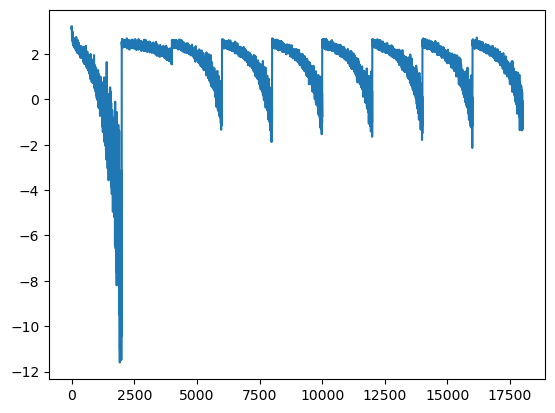

In [10]:
plt.plot(lowest_loss_model.log['total'])

In [ ]:
model_list = []
for model_path in os.listdir('models/single_session-v2/'):
  model = torch.load('models/single_session-v2/' + model_path).model
  model_list.append(model)
  print(model_path)
# convert into torch model list
model_list = torch.nn.ModuleList(model_list)
# save model list
torch.save(model_list, 'models/single_session-v2/cebra_model_list.pt')

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Adjust figsize as per your requirements
axes[0].plot(model.log['total'])  # Replace x1 and y1 with your data for the first plot
axes[0].set_title('total Loss 1')

# Plot the second value
axes[1].plot(model.log['pos'])  # Replace x2 and y2 with your data for the second plot
axes[1].set_title('Positive sample Loss')

# Plot the third value
axes[2].plot(model.log['neg'])  # Replace x3 and y3 with your data for the third plot
axes[2].set_title('negative sample loss')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()